In [1]:
from os import listdir

import csv
import numpy as np
import glob

from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import cross_val_score, train_test_split

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras import backend as K

from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.metrics import top_k_categorical_accuracy

Using TensorFlow backend.


In [6]:
# width and height of the input images
width = 96

# dictionary mapping integers types to words
types_dict = {
    0: 'bug',
    1: 'dark',
    2: 'dragon',
    3: 'electric',
    4: 'fairy',
    5: 'fighting',
    6: 'fire',
    7: 'flying',
    8: 'ghost',
    9: 'grass',
    10: 'ground',
    11: 'ice',
    12: 'normal',
    13: 'poison',
    14: 'psychic',
    15: 'rock',
    16: 'steel',
    17: 'water',
 }

In [7]:
# Function to plot images in n_col x n_row grid
def plot_images(images, n_col=3, n_row=2):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape((width, width, 3)),
                   interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [8]:
# We make from the file types.csv a dictionaty mapping each filename to a pair of types, where -1
# on the second place represents that given pokemon has only one type.
types_file = open('types.csv', 'r')
types = {}
for line in types_file.readlines():
    args = line[:-1].split(',')
    types[args[0]] = (int(args[1]), int(args[2]) if len(args[2]) > 0 else -1)

In [30]:
# We load images from directories and build from them array of features x and array of target values y.
directories = ['5', '5b', '5bf', '5f', '6', '6b', '6bf', '6f', '4', 'off']
images = []
y_types = []
y_matrix = []
# inttype = 6  # fire
for dirc in directories:
    for fname in listdir('all/' + dirc + '/'):
        path = 'all/' + dirc + '/' + fname
        # Remove oppacity channel if there is any
        images.append(mpimg.imread(path)[:,:,:3])
        y_matrix.append([0] * 18)
        for t in types[fname]:
            if t != -1:
                y_matrix[-1][t] = 1
x = np.array(images)
# y = np.array(target_vals)
y = np.array(y_matrix)
print(x.shape)
print(y.shape)

(4778, 96, 96, 3)
(4778, 18)


In [31]:
# Normalize and split data into training, validation and test set
mean = np.mean(x, axis=0)

X_train = x[:-720 -553] - mean
y_train = y[:-720 -553]

X_val = x[-720 - 553:-720] - mean
y_val = y[-720 - 553:-720]

X_test = x[-720:] - mean
y_test = y[-720:]

print(X_train.shape, X_val.shape, X_test.shape)

(3505, 96, 96, 3) (553, 96, 96, 3) (720, 96, 96, 3)


In [11]:
# custom metrics for evaluating our model
def inTop5(x, y):
    return top_k_categorical_accuracy(x, y, k=5)

In [10]:
kernel_size = (3, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size, input_shape=(96, 96, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(18))
model.add(Activation('sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy', inTop5]
)

In [35]:
# We use checkpointer so we are able to load model with best tradeof between training and validation loss.
checkpointer = ModelCheckpoint(filepath='CNmodels/norm7-{epoch:02d}.hdf5', verbose=0)

In [36]:
history1 = model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val), callbacks=[checkpointer], shuffle=True)

0.88363331938
Train on 3505 samples, validate on 553 samples
Epoch 1/10
3505/3505 [==============================] - 99s 28ms/step - loss: 0.0546 - acc: 0.9794 - inTop5: 0.9886 - val_loss: 0.2411 - val_acc: 0.9343 - val_inTop5: 0.8517
Epoch 2/10
3505/3505 [==============================] - 99s 28ms/step - loss: 0.0514 - acc: 0.9803 - inTop5: 0.9929 - val_loss: 0.2337 - val_acc: 0.9353 - val_inTop5: 0.8680
Epoch 3/10
3505/3505 [==============================] - 96s 28ms/step - loss: 0.0521 - acc: 0.9801 - inTop5: 0.9926 - val_loss: 0.2478 - val_acc: 0.9344 - val_inTop5: 0.8517
Epoch 4/10
3505/3505 [==============================] - 100s 29ms/step - loss: 0.0493 - acc: 0.9808 - inTop5: 0.9932 - val_loss: 0.2500 - val_acc: 0.9354 - val_inTop5: 0.8608
Epoch 5/10
3505/3505 [==============================] - 101s 29ms/step - loss: 0.0493 - acc: 0.9811 - inTop5: 0.9946 - val_loss: 0.2504 - val_acc: 0.9366 - val_inTop5: 0.8644
Epoch 6/10
3505/3505 [==============================] - 105s 30ms/s

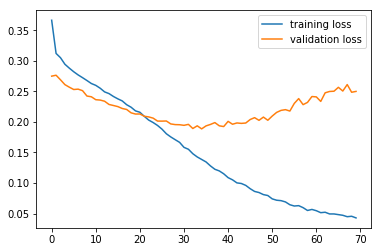

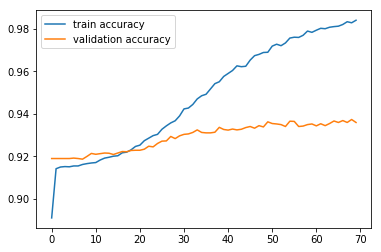

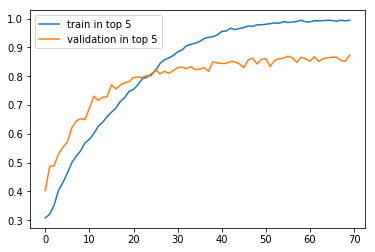

In [5]:
# score = model.evaluate(X_val, y_val)
# print("\n\nloss: {} | train acc: {}".format(score[0], score[1]))

hist = np.loadtxt('losses2.csv', delimiter=',', skiprows=1)


# Plot the behaviour of loss and accuary metrics.
plt.figure()
plt.plot(hist[:,0], label='training loss')
plt.plot(hist[:,3], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(hist[:,1], label='train accuracy')
plt.plot(hist[:,4], label='validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(hist[:,2], label='train in top 5')
plt.plot(hist[:,5], label='validation in top 5')
plt.legend(loc='best')
plt.show()



In [14]:
# Load model
model = load_model('CNmodels/norm7-40.hdf5',  custom_objects={'inTop5': inTop5})

In [26]:
model.evaluate(X_test, y_test)

720/720 [==============================] - 6s 8ms/step


[0.25101496378580729, 0.9225308471255832, 0.6958333333333333]

fighting (0.137605) bug (0.124075) electric (0.061367) flying (0.047225) grass (0.036962) 
normal (0.399214) fighting (0.308374) flying (0.285698) psychic (0.049995) fire (0.043768) 
psychic (0.636770) electric (0.551509) fighting (0.098124) grass (0.054569) steel (0.037068) 
grass (0.899102) poison (0.070049) electric (0.069599) steel (0.044702) psychic (0.039732) 
water (0.763323) electric (0.403557) ice (0.026146) bug (0.017270) ghost (0.010320) 
grass (0.960950) poison (0.080061) dragon (0.042740) ice (0.020174) psychic (0.018333) 
psychic (0.566101) ground (0.113081) dragon (0.056656) steel (0.047905) flying (0.038234) 
fighting (0.736330) steel (0.160198) psychic (0.088413) poison (0.059265) dark (0.030356) 
psychic (0.767470) normal (0.604005) fighting (0.187556) grass (0.022698) bug (0.018714) 
grass (0.882262) bug (0.191541) ground (0.134538) water (0.072294) psychic (0.067232) 
dark (0.485477) steel (0.228702) flying (0.126005) electric (0.120397) bug (0.111857) 
fairy (0.349

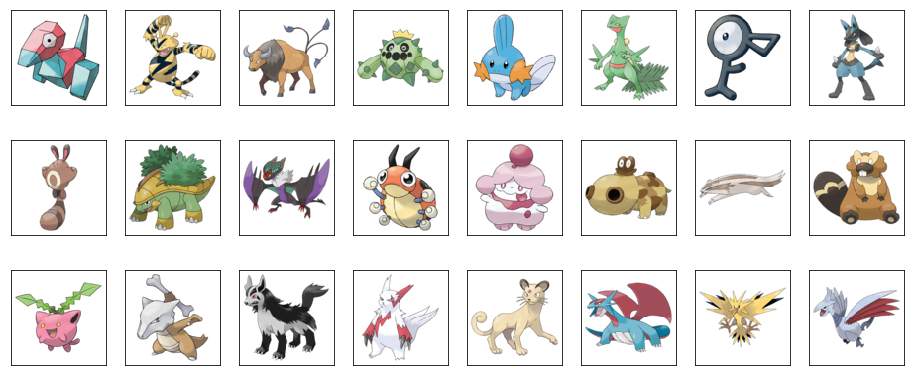

In [32]:
# Show prediction for images in array control
control = X_test[:24]
predicted = model2.predict(control)
for i in range(len(control)):
    for j in sorted(range(predicted.shape[1]), key=lambda k: -predicted[i][k])[:5]:
        print('%s (%2f)' % (types_dict[j], predicted[i][j]), end=' ')
    print()
plot_images(control + mean, 8, 3)
plt.show()